## Packages

In [157]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat

import os
os.getcwd()

from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


import folium

import scipy.stats as stats


## Functions

In [15]:
#turns geotiff into a grd
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    #makes latitude increase upwards, flips the matrix upsidedown
    z = np.flipud(band.ReadAsArray())
    width = img.RasterXSize
    height = img.RasterYSize
    #tells the bounding box in the real world
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    #linspace makes a list of numbers 
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

In [16]:
def parascatter(df,xs,ys,xerrs=None,yerrs=None,size=3,
                s=None,lw=None,color=None,scale='linear',wspace=0.3,hspace=0.4):
    plt.figure(figsize=(len(ys)*size,len(xs)*size))
    for i in range(len(xs)):
        for j in range(len(ys)):
            plt.subplot(len(xs),len(ys),j+i*len(ys)+1)
            plt.scatter(df[xs[i]],df[ys[j]],
                        s=s,color=color,lw=lw)
            if xerrs:
                plt.plot([df[xs[i]]-df[xerrs[i]],df[xs[i]]+df[xerrs[i]]],
                         [df[ys[j]],df[ys[j]]],
                         color=color,lw=lw)
            if yerrs:
                plt.plot([df[xs[i]],df[xs[i]]],
                         [df[ys[j]]-df[yerrs[j]],df[ys[j]]+df[yerrs[j]]],
                         color=color,lw=lw)
            plt.xscale(scale)
            plt.yscale(scale)
            plt.xlabel(xs[i])
            plt.ylabel(ys[j])
    plt.subplots_adjust(wspace=wspace,hspace=hspace)

In [159]:
def get_r2(x,y):
    polyfit = np.polyfit(x,y,1)
    y_predicted = np.polyval(polyfit,x)
    residuals = y-y_predicted
    return 1-np.sum(residuals**2)/np.sum((y-np.mean(y))**2)

def get_percentiles(x):
    y_percentiles = np.arange(101)
    x_percentiles = [np.percentile(x,y_percentiles[i]) for i in range(len(y_percentiles))]
    return x_percentiles,y_percentiles

def get_realpdf(x,y,nbins):
    polyfit = np.polyfit(x,y,1)
    y_predicted = np.polyval(polyfit,x)
    residuals = y-y_predicted    
    bins    = np.linspace(-np.max(np.abs(residuals)),np.max(np.abs(residuals)),nbins)
    binmids = bins[1:] - np.diff(bins)/2
    bindensity,_ = np.histogram(residuals,bins=bins,density=True)
    return bindensity,binmids,bins

def get_normalpdf(x,y,binmids):
    polyfit = np.polyfit(x,y,1)
    y_predicted = np.polyval(polyfit,x)
    residuals = y-y_predicted
    mean = np.mean(residuals)
    std = np.std(residuals)
    return stats.norm.pdf(binmids,mean,std)

def get_powerlaw_constants(x,y):
    polyfit = np.polyfit(np.log10(x),np.log10(y),1)
    l,n = 10**polyfit[1],polyfit[0]
    return l,n

## Geotiffs

In [17]:
TMI_geotiff = gdal.Open('/Users/aaronsuaiso/Documents/2024/Data_analysis/Final_Project/Geotiffs/TMI.tif')
lon_geotiff,lat_geotiff, TMI = xyz_geotiff(TMI_geotiff)

RTP_geotiff = gdal.Open('/Users/aaronsuaiso/Documents/2024/Data_analysis/Final_Project/Geotiffs/TMI_RTP.tif')
lon_RTP, lat_RTP, RTP = xyz_geotiff(RTP_geotiff)

RTP_1VD_geotiff = gdal.Open('/Users/aaronsuaiso/Documents/2024/Data_analysis/Final_Project/Geotiffs/TMI_RTP_1VD.tif')
lon_RTP_1VD, lat_RTP_1VD, RTP_1VD = xyz_geotiff(RTP_1VD_geotiff)

K_geotiff = gdal.Open('/Users/aaronsuaiso/Documents/2024/Data_analysis/Final_Project/Geotiffs/Potassium.tif')
lon_K, lat_K, K = xyz_geotiff(K_geotiff)

U_geotiff = gdal.Open('/Users/aaronsuaiso/Documents/2024/Data_analysis/Final_Project/Geotiffs/Uranium.tif')
lon_U, lat_U, U = xyz_geotiff(U_geotiff)

Th_geotiff = gdal.Open('/Users/aaronsuaiso/Documents/2024/Data_analysis/Final_Project/Geotiffs/Thorium.tif')
lon_Th, lat_Th, Th = xyz_geotiff(Th_geotiff)

GRAV_geotiff = gdal.Open('/Users/aaronsuaiso/Documents/2024/Data_analysis/Final_Project/Geotiffs/Gravity.tif')
lon_grav, lat_grav, Density = xyz_geotiff(GRAV_geotiff)



## Plots

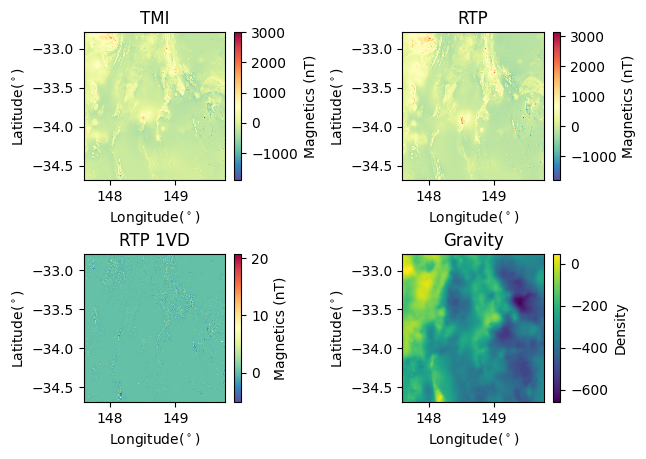

In [75]:

plt.subplot(221)

plt.pcolormesh(lon_geotiff,lat_geotiff,TMI, cmap = 'Spectral_r')
plt.colorbar(label='Magnetics (nT)')
plt.title('TMI')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')

plt.subplot(222)

plt.pcolormesh(lon_RTP, lat_RTP, RTP, cmap = 'Spectral_r')
plt.colorbar(label='Magnetics (nT)')
plt.title('RTP')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')

plt.subplot(223)

plt.pcolormesh(lon_RTP_1VD, lat_RTP_1VD, RTP_1VD, cmap = 'Spectral_r')
plt.colorbar(label='Magnetics (nT)')
plt.title('RTP 1VD')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')

plt.subplot(224)

plt.pcolormesh(lon_grav, lat_grav, Density)
plt.colorbar(label='Density')
plt.title('Gravity')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')


plt.subplots_adjust(hspace=0.5,wspace=0.8)

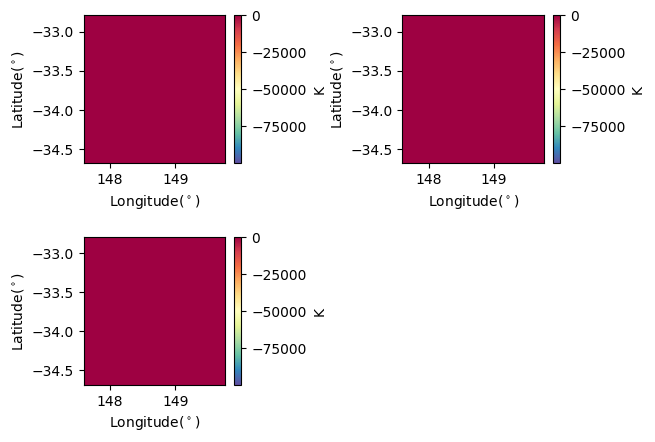

In [40]:
plt.subplot(221)

plt.pcolormesh(lon_K,lat_K,K, cmap = 'Spectral_r')
plt.colorbar(label='K')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')

plt.subplot(222)

plt.pcolormesh(lon_Th,lat_Th,Th, cmap = 'Spectral_r')
plt.colorbar(label='K')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')

plt.subplot(223)

plt.pcolormesh(lon_U,lat_U,U, cmap = 'Spectral_r')
plt.colorbar(label='K')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')

plt.subplots_adjust(hspace=0.5,wspace=0.8)

In [23]:
np.shape(U)

(1892, 2172)

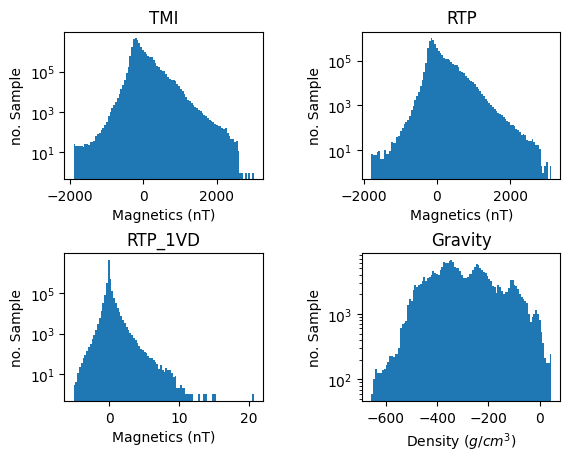

In [168]:
# np.histogram()
plt.subplot(221)
plt.title('TMI')
m = plt.hist(TMI.flatten(),bins=100,log=True)
plt.xlabel('Magnetics (nT)')
plt.ylabel('no. Sample')

plt.subplot(222)
plt.title('RTP')
r = m = plt.hist(RTP.flatten(),bins=100,log=True)
plt.xlabel('Magnetics (nT)')
plt.ylabel('no. Sample')

plt.subplot(223)
plt.title('RTP_1VD')
r = m = plt.hist(RTP_1VD.flatten(),bins=100,log=True)
plt.xlabel('Magnetics (nT)')
plt.ylabel('no. Sample')

plt.subplot(224)
plt.title('Gravity')
m = plt.hist(Density.flatten(),bins=100,log=True)
plt.xlabel('Density ($g/cm^{3}$)')
plt.ylabel('no. Sample')

plt.subplots_adjust(hspace=0.5,wspace=0.5)

## Combining data to a single CSV

In [21]:
lon = lon_geotiff.flatten()
lat = lat_geotiff.flatten()
T = TMI.flatten()
R = RTP.flatten()
VD = RTP_1VD.flatten()
G = Density.flatten()
K_f = K.flatten()
U_f = U.flatten()
Th_f = Th.flatten()

import csv

# Combine the arrays into a list of rows
rows = zip(lon, lat, T, R, VD, G, K_f, U_f, Th_f)

# Specify the CSV file name
csv_file = 'Geotiff_4.csv'

# Write the arrays as columns to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Lon", "Lat", "TMI", "RTP", "RTP_1VD", "Gravity", "Potassium", "Uranium", "Thorium"])
    
    # Write the data rows
    writer.writerows(rows)

print(f"Arrays added to {csv_file} successfully.")

Arrays added to Geotiff_4.csv successfully.


In [22]:
pd.read_csv('Geotiff_4.csv')

,Lon,Lat,TMI,RTP,RTP_1VD,Gravity,Potassium,Uranium,Thorium
0,147.594400,-34.6820,20.713749,122.673530,0.037690,-222.31577,1.003654,1.676247,13.312036
1,147.594800,-34.6816,20.871664,122.127970,0.033660,-222.36856,0.999994,1.596442,13.077322
2,147.595200,-34.6812,20.699118,120.198830,0.016738,-221.92747,0.981510,1.549802,12.968199
3,147.595600,-34.6808,20.158945,117.726820,-0.005637,-220.83421,0.964125,1.539026,12.699212
4,147.596000,-34.6804,19.338972,116.337710,-0.018900,-218.99576,0.957089,1.553515,12.259950
...,...,...,...,...,...,...,...,...,...
4725,149.484748,-32.7916,-151.928310,-99.294360,0.009090,-336.20180,1.036423,1.715450,12.205122
4726,149.485148,-32.7912,-151.694780,-100.905890,0.005261,-337.75730,1.044748,1.765375,12.231481
4727,149.485548,-32.7908,-151.423370,-102.474240,0.002714,-339.70496,1.054572,1.808337,12.494862
4728,149.485948,-32.7904,-151.060400,-103.824196,0.003347,-342.00034,1.045514,1.817042,12.755610


## Clustering Plots

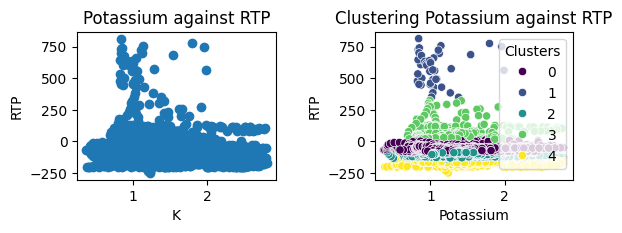

In [84]:
plt.subplot(221)
df = pd.read_csv('Geotiff_4.csv')

df.shape

x = (df['Potassium'])
y = (df['RTP'])

plt.scatter(x, y)

# Set the aspect ratio to 'auto' to prevent automatic equal scaling
plt.gca().set_aspect('auto', adjustable='box')

# Set labels and title
plt.xlabel('K')
plt.ylabel('RTP')
plt.title('Potassium against RTP')

plt.subplot(222)
km=KMeans(n_clusters=5)
y_predicted = km.fit_predict(df[['RTP','Potassium']])
y_predicted

km.cluster_centers_

df['Clusters'] = km.labels_
sns.scatterplot(x="Potassium", y="RTP",hue = 'Clusters',  data=df,palette='viridis')
plt.title('Clustering Potassium against RTP')

plt.subplots_adjust(hspace=0.5,wspace=0.5)

Text(0.5, 1.0, 'RTP against Potassium')

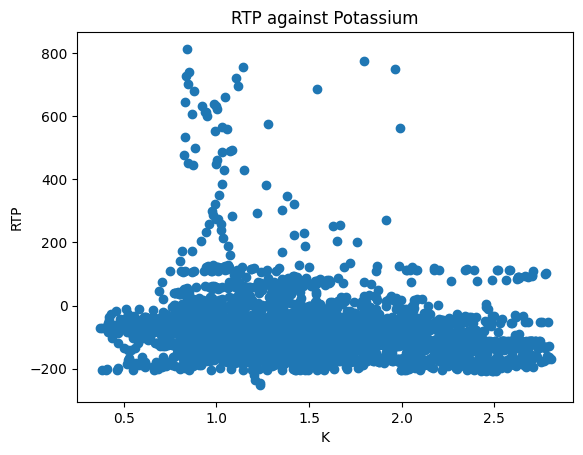

In [175]:
df = pd.read_csv('Geotiff_4.csv')

df.shape

x = (df['Potassium'])
y = (df['RTP'])

plt.scatter(x, y)

# Set the aspect ratio to 'auto' to prevent automatic equal scaling
plt.gca().set_aspect('auto', adjustable='box')

# Set labels and title
plt.xlabel('K')
plt.ylabel('RTP')
plt.title('RTP against Potassium')



In [166]:
stats.linregress(K_f, R)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4109424 and the array at index 1 has size 5692212

Text(0.5, 1.0, 'Scatter Plot with Non-Equal Axes')

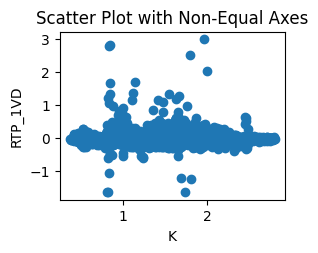

In [76]:
plt.subplot(221)
df = pd.read_csv('Geotiff_4.csv')

df.shape

x = (df['Potassium'])
y = (df['RTP_1VD'])

plt.scatter(x, y)

# Set the aspect ratio to 'auto' to prevent automatic equal scaling
plt.gca().set_aspect('auto', adjustable='box')

# Set labels and title
plt.xlabel('K')
plt.ylabel('RTP_1VD')
plt.title('Scatter Plot with Non-Equal Axes')



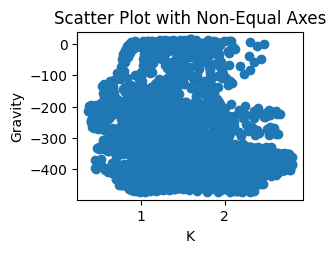

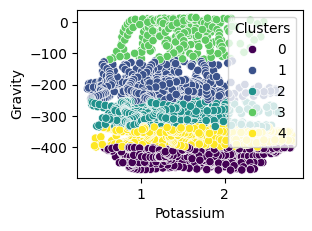

In [73]:
plt.subplot(221)
df = pd.read_csv('Geotiff_4.csv')

df.shape

x = (df['Potassium'])
y = (df['Gravity'])

plt.scatter(x, y)

# Set the aspect ratio to 'auto' to prevent automatic equal scaling
plt.gca().set_aspect('auto', adjustable='box')

# Set labels and title
plt.xlabel('K')
plt.ylabel('Gravity')
plt.title('Scatter Plot with Non-Equal Axes')

plt.show()

plt.subplot(222)
km=KMeans(n_clusters=5)
y_predicted = km.fit_predict(df[['Gravity','Potassium']])
y_predicted

km.cluster_centers_

df['Clusters'] = km.labels_
sns.scatterplot(x="Potassium", y="Gravity",hue = 'Clusters',  data=df,palette='viridis')

plt.show()

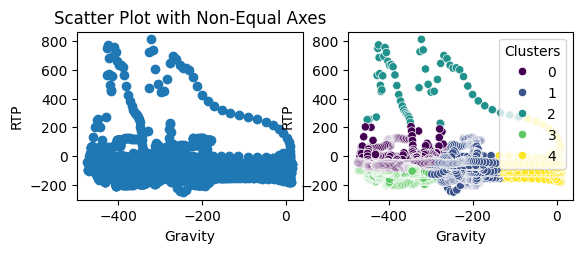

In [74]:
plt.subplot(221)
df = pd.read_csv('Geotiff_4.csv')

df.shape

x = (df['Gravity'])
y = (df['RTP'])

plt.scatter(x, y)

# Set the aspect ratio to 'auto' to prevent automatic equal scaling
plt.gca().set_aspect('auto', adjustable='box')

# Set labels and title
plt.xlabel('Gravity')
plt.ylabel('RTP')
plt.title('Scatter Plot with Non-Equal Axes')

plt.subplot(222)
km=KMeans(n_clusters=5)
y_predicted = km.fit_predict(df[['RTP','Gravity']])
y_predicted

km.cluster_centers_

df['Clusters'] = km.labels_
sns.scatterplot(x="Gravity", y="RTP",hue = 'Clusters',  data=df,palette='viridis')

plt.show()

## Elbow Test and Clustering

In [55]:
# Load data from CSV file
data = pd.read_csv('Geotiff_4.csv')

# Select columns for clustering and scatter plot (Magnetics, Gravity, Radiometrics, Longitude, Latitude)
selected_columns = ['RTP', 'Gravity', 'Potassium', 'Lon', 'Lat']
X = data[selected_columns]

# Perform K-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(X[['RTP', 'Gravity', 'Potassium']])
centroids = kmeans.cluster_centers_

# Create Folium map
map_center = [np.mean(data['Lat']), np.mean(data['Lon'])]
mymap = folium.Map(location=map_center, zoom_start=10)

# Add cluster points to the map
for i in range(len(data)):
    color = 'red' if cluster_labels[i] == 0 else 'blue' if cluster_labels[i] == 1 else 'green'
    folium.CircleMarker(location=[data.iloc[i]['Lat'], data.iloc[i]['Lon']], radius=5, color=color, fill_color=color, fill_opacity=0.5).add_to(mymap)

# Add centroids to the map
for centroid in centroids:
    folium.Marker(location=[centroid[1], centroid[2]], popup='Centroid', icon=folium.Icon(color='black')).add_to(mymap)

# Save the map to an HTML file
mymap.save('kmeans_clusters_map 2.html')

In [35]:
df = pd.read_csv('Geotiff_4.csv')

df.shape

#apply scaling feature
scaler = MinMaxScaler()
scale = scaler.fit_transform(df[['Potassium','RTP']])
df_scale = pd.DataFrame(scale, columns = ['Potassium','RTP']);
df_scale.head(5)

,Potassium,RTP
0,0.260337,0.351436
1,0.258833,0.350923
2,0.251237,0.349109
3,0.244092,0.346785
4,0.241201,0.345479


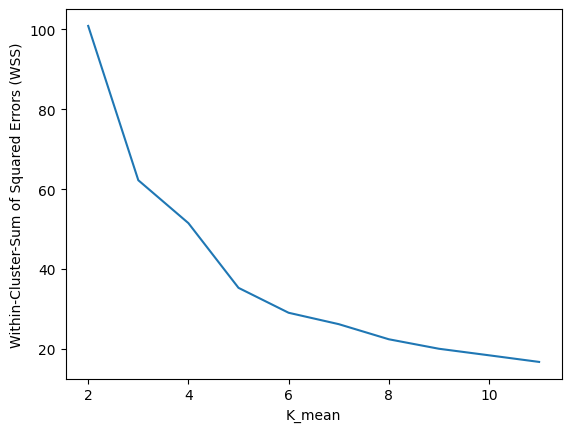

In [36]:
K_mean = range(2,12)
wss = []

for k in K_mean:
    kmeans=cluster.KMeans(n_clusters=k)
    kmeans=kmeans.fit(df_scale)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

plt.xlabel('K_mean')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K_mean,wss)

plt.show()

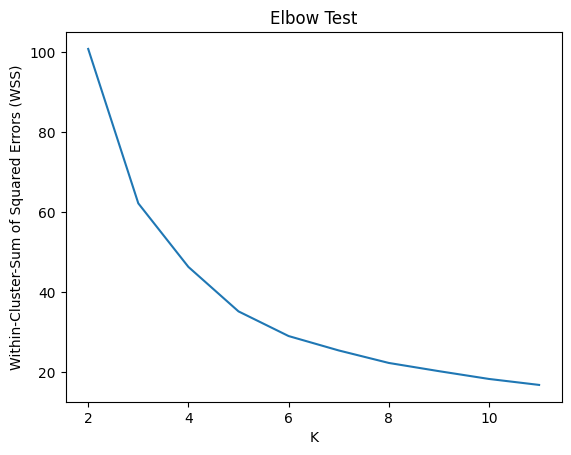

In [137]:
#finding optimum value of K
K=range(2,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k)
    kmeans=kmeans.fit(pca_df)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss)
plt.title ('Elbow Test')
plt.show()

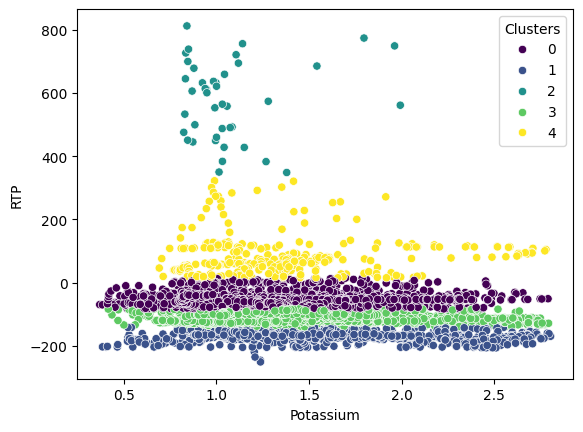

In [118]:
km=KMeans(n_clusters=5)
y_predicted = km.fit_predict(df[['RTP','Potassium']])
y_predicted

km.cluster_centers_

df['Clusters'] = km.labels_
sns.scatterplot(x="Potassium", y="RTP",hue = 'Clusters',  data=df,palette='viridis')

plt.show()

In [135]:
df = pd.read_csv(r"Geotiff_4.csv")
df.head()

scaler_2 = MinMaxScaler()

scale_2 = scaler.fit_transform(df[['Potassium','RTP']])

df_scale_2 = pd.DataFrame(scale, columns = ['Potassium', 'RTP']);
df_scale_2.head(5)



,Potassium,RTP
0,0.260337,0.351436
1,0.258833,0.350923
2,0.251237,0.349109
3,0.244092,0.346785
4,0.241201,0.345479


In [136]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scale)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
pca_df.head()



,principal component 1,principal component 2
0,-0.191357,0.174902
1,-0.192819,0.174278
2,-0.200257,0.171898
3,-0.207207,0.169043
4,-0.209992,0.167524


Text(0, 0.5, 'RTP')

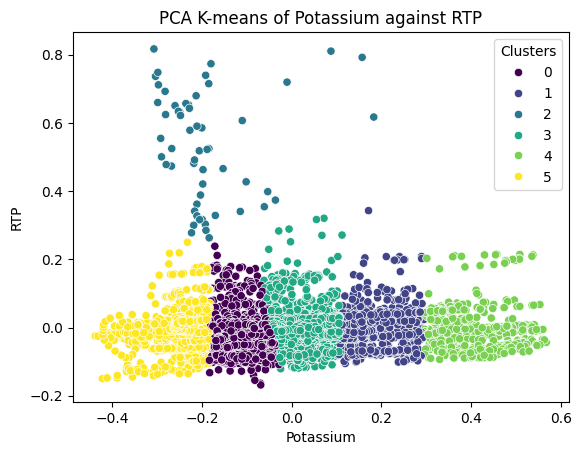

In [138]:
kmeans = cluster.KMeans(n_clusters=6)
kmeans = kmeans.fit(pca_df)

pca_df['Clusters'] = kmeans.labels_
plt.title('PCA K-means of Potassium against RTP')

sns.scatterplot(x="principal component 1", y="principal component 2",hue = 'Clusters',  data=pca_df,palette='viridis')
plt.xlabel('Potassium')
plt.ylabel('RTP')

## kmeans Map

/var/folders/p4/p18rpg5j6gxflfyc88tngbs40000gn/T/ipykernel_96434/2347148800.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cluster_data['Lon'], cluster_data['Lat'], label=f'Cluster {i+1}', cmap = 'Spectral')


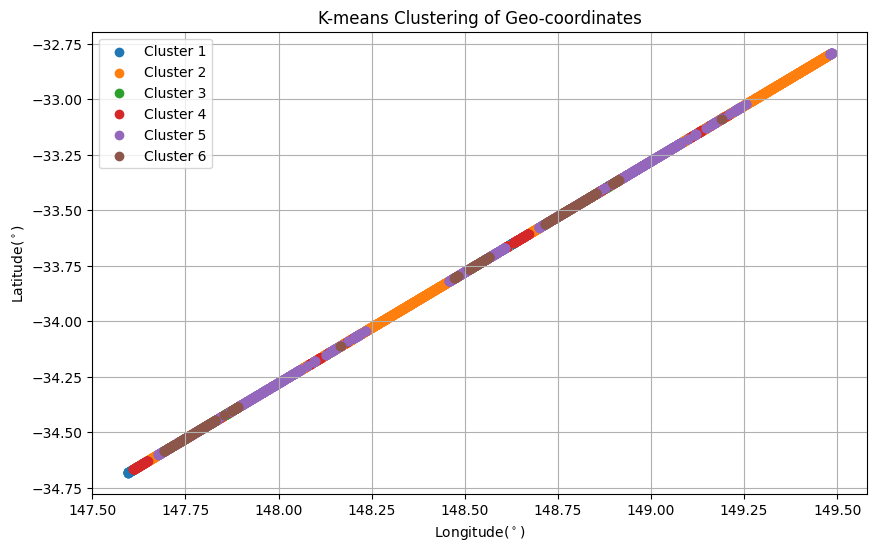

In [142]:


# Load data from CSV file
data = pd.read_csv('Geotiff_4.csv')

# Select columns for clustering (e.g., Density, Magnetics, Radiometrics, Longitude, Latitude)
selected_columns = ['RTP', 'Potassium', 'Lon', 'Lat']
data = data[selected_columns]

# Perform K-means clustering
k = 6  # Number of clusters
kmeans = KMeans(n_clusters=6, random_state=0)
cluster_labels = kmeans.fit_predict(data[['RTP', 'Potassium']])
data['Cluster'] = cluster_labels
centroids = kmeans.cluster_centers_

# Plot clusters using matplotlib
plt.figure(figsize=(10, 6))
for i in range(k):
    cluster_data = data[data['Cluster'] == i]
    plt.scatter(cluster_data['Lon'], cluster_data['Lat'], label=f'Cluster {i+1}', cmap = 'Spectral')
#plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.xlabel('Longitude($^\\circ$)')
plt.ylabel('Latitude($^\\circ$)')
plt.title('K-means Clustering of Geo-coordinates')
plt.legend()
plt.grid(True)

plt.show()

# Create a Folium map
map_center = [np.mean(lat), np.mean(lon)]  # Use the mean latitude and longitude as the map center
mymap = folium.Map(location=map_center, zoom_start=10)

# Add cluster points to the map
for i in range(len(data)):
    color = 'red' if cluster_labels[i] == 0 else 'blue' if cluster_labels[i] == 1 else 'green'
    folium.CircleMarker(location=[lat[i], lon[i]], radius=5, color=color, fill_color=color, fill_opacity=0.5).add_to(mymap)

# Add centroids to the map
for centroid in centroids:
    folium.Marker(location=[centroid[1], centroid[0]], popup='Centroid', icon=folium.Icon(color='black')).add_to(mymap)

mymap.save('kmeans_clusters_map.html')